<a href="https://colab.research.google.com/github/WoradeeKongthong/nature_multilabel_image_classification/blob/main/multilabel_nature_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import pandas as pd
import random
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16

# Clone repository

In [2]:
# clone the data from my repository
!git clone https://github.com/WoradeeKongthong/nature_multilabel_image_classification.git

Cloning into 'nature_multilabel_image_classification'...
remote: Enumerating objects: 2077, done.
remote: Counting objects: 100% (2077/2077), done.
remote: Compressing objects: 100% (2062/2062), done.
remote: Total 2077 (delta 26), reused 2046 (delta 10), pack-reused 0
Receiving objects: 100% (2077/2077), 218.51 MiB | 35.50 MiB/s, done.
Resolving deltas: 100% (26/26), done.


# Visualize Dataset

In [3]:
# get list of file name
images = os.listdir('/content/nature_multilabel_image_classification/miml_dataset/images')

In [4]:
# get labels
labels_df = pd.read_csv('/content/nature_multilabel_image_classification/miml_dataset/miml_labels_2.csv',  index_col='Filenames')

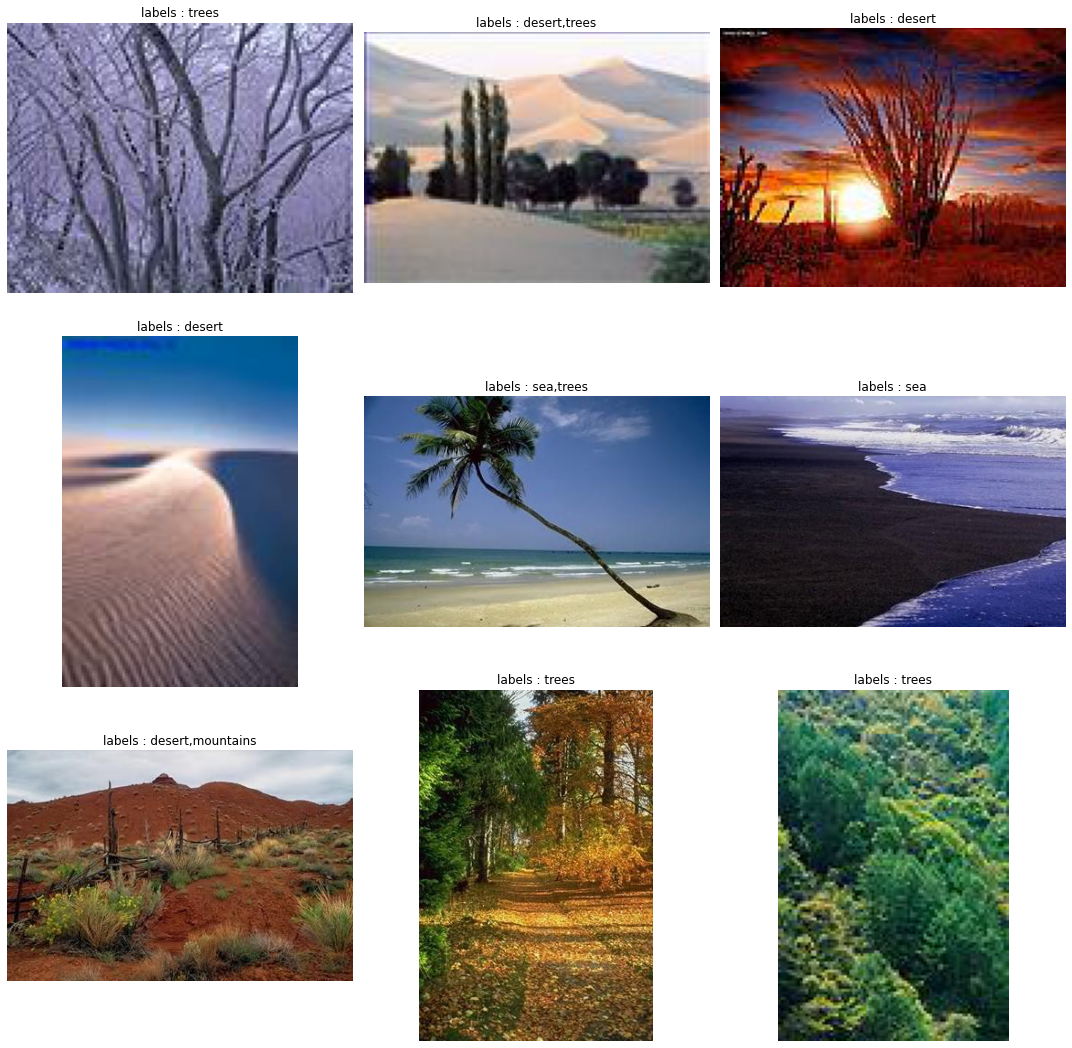

In [5]:
# plot sample images
fig = plt.figure(figsize=(15,15))
for i,image in enumerate(random.sample(images, 9)):
  # read image
  img = imread('/content/nature_multilabel_image_classification/miml_dataset/images/'+image)
  # subplot 
  fig.add_subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"labels : {labels_df.loc[image]['labels']}")
fig.tight_layout()
plt.show()

# Data pre-processing

## Create labels map

In [10]:
# find all labels
labels = set()
for i in range(len(labels_df)):
    tags = labels_df['labels'][i].split(',')
    # update labels with this tags
    labels.update(tags)

labels

{'desert', 'mountains', 'sea', 'sunset', 'trees'}

In [11]:
# convert set of labels to list
labels = list(labels)
labels.sort()

# create labels to integers mapping
labels_map = {labels[i]:i for i in range(len(labels))}

# create reverse integers to labels mapping
inv_labels_map = {i:labels[i] for i in range(len(labels))}

print(labels_map)
print(inv_labels_map)

{'desert': 0, 'mountains': 1, 'sea': 2, 'sunset': 3, 'trees': 4}
{0: 'desert', 1: 'mountains', 2: 'sea', 3: 'sunset', 4: 'trees'}


In [12]:
# save the labels_mp and inv_labels_map for use later in other files
json.dump(labels_map, open('labels_map.json','w'))
json.dump(inv_labels_map, open('inv_labels_map.json','w'))

## Create in-memory dataset (X,y)

In [13]:
X = list()
y = list()

for image in images:
    # load image
    img = load_img('/content/nature_multilabel_image_classification/miml_dataset/images/'+image, 
                   target_size=(128,128))
    # convert to numpy array
    img = img_to_array(img, dtype='uint8')
    
    # append loaded image to image list
    X.append(img)
    
    # get tags or labels
    tags = labels_df.loc[image]['labels']
    # create empty numpy array
    encoding = np.zeros(len(labels_map), dtype='uint8')
    # mark 1 for matched tags
    for tag in tags.split(','):
        encoding[labels_map[tag]]=1
    
    # append targets with encoding array
    y.append(encoding)

# convert X and y to array
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(2000, 128, 128, 3)
(2000, 5)


================Example================


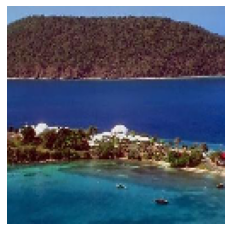


image array shape :  (128, 128, 3)

target array : 

['desert', 'mountains', 'sea', 'sunset', 'trees']  :  [0 0 1 0 0]


In [14]:
# check in-memory dataset
idx = random.randint(0, X.shape[0]-1)
print('================Example================')
plt.imshow(X[idx])
plt.axis('off')
plt.show()
print('\nimage array shape : ', X[idx].shape)
print('\ntarget array : \n')
print(labels, ' : ', y[idx])

## Create train and test sets
(validation set will be created with data generator)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create image data generator with data augmentation

In [23]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# Baseline model

## Create fbeta metric

In [17]:
# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Create function for showing result

In [18]:
# create function for plotting (loss and fbeta score)

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

## Baseline model : 3 VGG blocks

In [19]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

Epoch 1/100
40/40 [==============================] - 7s 156ms/step - loss: 0.6078 - fbeta: 0.0513 - val_loss: 0.5562 - val_fbeta: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 6s 146ms/step - loss: 0.5582 - fbeta: 0.0000e+00 - val_loss: 0.5454 - val_fbeta: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 6s 149ms/step - loss: 0.5165 - fbeta: 0.0832 - val_loss: 0.4667 - val_fbeta: 0.2509
Epoch 4/100
40/40 [==============================] - 6s 148ms/step - loss: 0.4685 - fbeta: 0.2549 - val_loss: 0.4177 - val_fbeta: 0.3452
Epoch 5/100
40/40 [==============================] - 6s 149ms/step - loss: 0.4196 - fbeta: 0.4173 - val_loss: 0.4182 - val_fbeta: 0.3998
Epoch 6/100
40/40 [==============================] - 6s 148ms/step - loss: 0.3886 - fbeta: 0.5295 - val_loss: 0.4018 - val_fbeta: 0.5014
Epoch 7/100
40/40 [==============================] - 6s 149ms/step - loss: 0.3724 - fbeta: 0.5443 - val_loss: 0.3663 - val_fbeta: 0.5595
Epoch 8/100
40/40 [==========

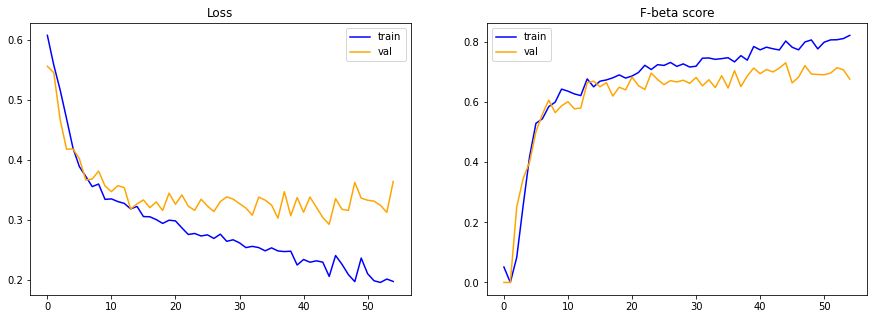

Model F-beta score :  0.7384507656097412


In [25]:
# define model input
visible = Input(shape=(128, 128, 3))

# add 3 vgg blocks
layer1 = vgg_block(visible, 64, 2)
layer2 = vgg_block(layer1, 128, 2)
layer3 = vgg_block(layer2, 256, 2)

# add fully connected part
flatten = Flatten()(layer3)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(fc1)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(fc2)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(fc3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=visible, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=100)

baseline_performance = evaluate_model(history)

# Improved model

## model 1 : 3 VGG blocks + Dropout layers

Epoch 1/100
40/40 [==============================] - 7s 157ms/step - loss: 0.5923 - fbeta: 0.0346 - val_loss: 0.5417 - val_fbeta: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 6s 145ms/step - loss: 0.5310 - fbeta: 0.0884 - val_loss: 0.4791 - val_fbeta: 0.1373
Epoch 3/100
40/40 [==============================] - 6s 147ms/step - loss: 0.4917 - fbeta: 0.1952 - val_loss: 0.4560 - val_fbeta: 0.2637
Epoch 4/100
40/40 [==============================] - 6s 143ms/step - loss: 0.4383 - fbeta: 0.3146 - val_loss: 0.4395 - val_fbeta: 0.3720
Epoch 5/100
40/40 [==============================] - 6s 146ms/step - loss: 0.4177 - fbeta: 0.4701 - val_loss: 0.4109 - val_fbeta: 0.4288
Epoch 6/100
40/40 [==============================] - 6s 144ms/step - loss: 0.3879 - fbeta: 0.5136 - val_loss: 0.3832 - val_fbeta: 0.5571
Epoch 7/100
40/40 [==============================] - 6s 144ms/step - loss: 0.3805 - fbeta: 0.5710 - val_loss: 0.4024 - val_fbeta: 0.5576
Epoch 8/100
40/40 [==================

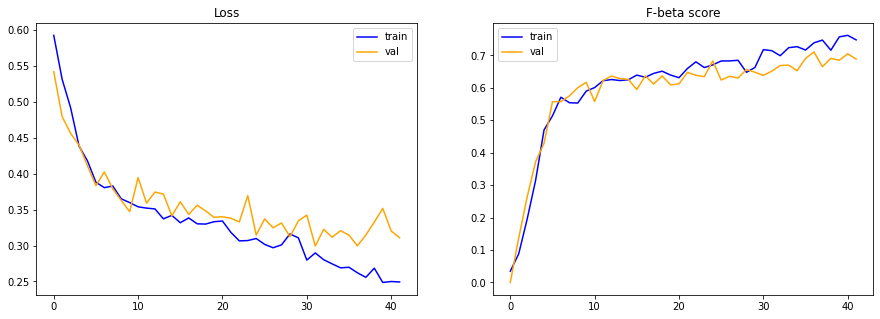

Model F-beta score :  0.7217350602149963


In [26]:
# define model input
visible = Input(shape=(128, 128, 3))

# add 3 vgg blocks
layer1 = vgg_block(visible, 64, 2)
layer2 = vgg_block(layer1, 128, 2)
layer3 = vgg_block(layer2, 256, 2)

# add fully connected part
flatten = Flatten()(layer3)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(fc2)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(fc3)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=visible, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=100)

model1_performance = evaluate_model(history)

## model 2 : model 1 + longer training and increase patience

Epoch 1/200
40/40 [==============================] - 7s 156ms/step - loss: 0.5766 - fbeta: 0.0280 - val_loss: 0.5516 - val_fbeta: 0.0000e+00
Epoch 2/200
40/40 [==============================] - 6s 149ms/step - loss: 0.5176 - fbeta: 0.1151 - val_loss: 0.4651 - val_fbeta: 0.2904
Epoch 3/200
40/40 [==============================] - 6s 148ms/step - loss: 0.4705 - fbeta: 0.3055 - val_loss: 0.4279 - val_fbeta: 0.4000
Epoch 4/200
40/40 [==============================] - 6s 151ms/step - loss: 0.4290 - fbeta: 0.3993 - val_loss: 0.3847 - val_fbeta: 0.5468
Epoch 5/200
40/40 [==============================] - 6s 147ms/step - loss: 0.4072 - fbeta: 0.5039 - val_loss: 0.3993 - val_fbeta: 0.5191
Epoch 6/200
40/40 [==============================] - 6s 147ms/step - loss: 0.3839 - fbeta: 0.5664 - val_loss: 0.3710 - val_fbeta: 0.5500
Epoch 7/200
40/40 [==============================] - 6s 147ms/step - loss: 0.3772 - fbeta: 0.5745 - val_loss: 0.3777 - val_fbeta: 0.5743
Epoch 8/200
40/40 [==================

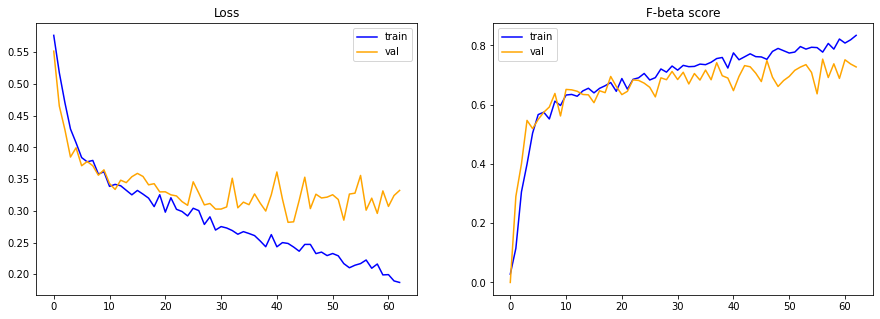

Model F-beta score :  0.7494246959686279


In [27]:
# define model input
visible = Input(shape=(128, 128, 3))

# add 3 vgg blocks
layer1 = vgg_block(visible, 64, 2)
layer2 = vgg_block(layer1, 128, 2)
layer3 = vgg_block(layer2, 256, 2)

# add fully connected part
flatten = Flatten()(layer3)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(fc2)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(fc3)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=visible, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model2_performance = evaluate_model(history)

## model 3 : pre-trained VGG16 as an integrated feature extractor

In [29]:
# create data generator with vgg16 preprocessing
train_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

batch_size = 32
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

Epoch 1/100
40/40 [==============================] - 8s 162ms/step - loss: 1.5804 - fbeta: 0.4955 - val_loss: 0.4487 - val_fbeta: 0.6314
Epoch 2/100
40/40 [==============================] - 6s 149ms/step - loss: 0.6158 - fbeta: 0.6187 - val_loss: 0.3306 - val_fbeta: 0.7137
Epoch 3/100
40/40 [==============================] - 6s 146ms/step - loss: 0.4364 - fbeta: 0.6813 - val_loss: 0.2757 - val_fbeta: 0.7492
Epoch 4/100
40/40 [==============================] - 6s 143ms/step - loss: 0.3887 - fbeta: 0.6963 - val_loss: 0.2587 - val_fbeta: 0.7791
Epoch 5/100
40/40 [==============================] - 6s 143ms/step - loss: 0.3479 - fbeta: 0.7334 - val_loss: 0.2530 - val_fbeta: 0.7963
Epoch 6/100
40/40 [==============================] - 6s 147ms/step - loss: 0.3058 - fbeta: 0.7495 - val_loss: 0.2626 - val_fbeta: 0.7783
Epoch 7/100
40/40 [==============================] - 6s 148ms/step - loss: 0.2890 - fbeta: 0.7756 - val_loss: 0.2430 - val_fbeta: 0.7776
Epoch 8/100
40/40 [======================

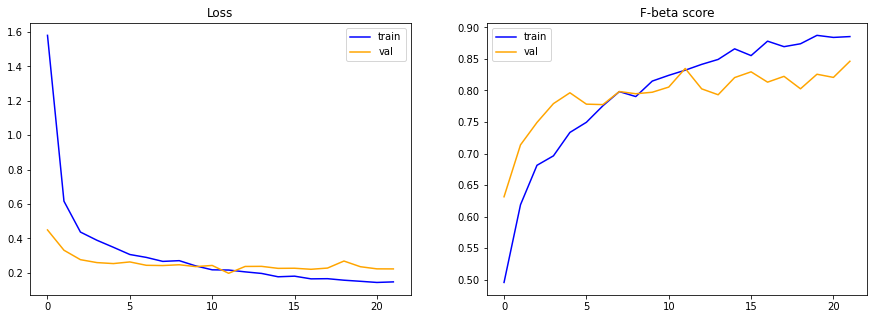

Model F-beta score :  0.85172438621521


In [32]:
# load VGG16 model
model = vgg16.VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add fully connected part
flatten = Flatten()(model.layers[-1].output)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(fc2)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(fc3)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=100)

model3_performance = evaluate_model(history)

## model 4 : model 3 + training longer and increase patience

Epoch 1/200
40/40 [==============================] - 7s 156ms/step - loss: 1.4697 - fbeta: 0.4671 - val_loss: 0.4224 - val_fbeta: 0.6334
Epoch 2/200
40/40 [==============================] - 6s 149ms/step - loss: 0.6024 - fbeta: 0.6040 - val_loss: 0.3209 - val_fbeta: 0.7506
Epoch 3/200
40/40 [==============================] - 6s 147ms/step - loss: 0.4553 - fbeta: 0.6795 - val_loss: 0.2594 - val_fbeta: 0.7493
Epoch 4/200
40/40 [==============================] - 6s 144ms/step - loss: 0.3647 - fbeta: 0.7098 - val_loss: 0.2531 - val_fbeta: 0.7680
Epoch 5/200
40/40 [==============================] - 6s 143ms/step - loss: 0.3341 - fbeta: 0.7199 - val_loss: 0.2618 - val_fbeta: 0.7399
Epoch 6/200
40/40 [==============================] - 6s 142ms/step - loss: 0.2961 - fbeta: 0.7630 - val_loss: 0.2363 - val_fbeta: 0.7583
Epoch 7/200
40/40 [==============================] - 6s 146ms/step - loss: 0.2622 - fbeta: 0.7753 - val_loss: 0.2391 - val_fbeta: 0.8048
Epoch 8/200
40/40 [======================

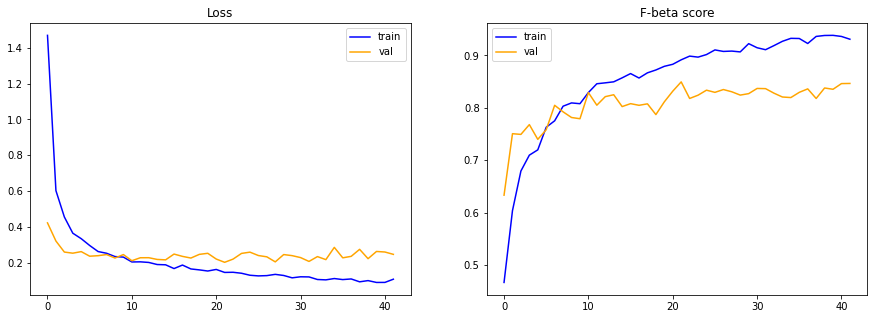

Model F-beta score :  0.8571411371231079


In [33]:
# load VGG16 model
model = vgg16.VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add fully connected part
flatten = Flatten()(model.layers[-1].output)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(fc2)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(fc3)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model4_performance = evaluate_model(history)

## model 5 : model 4 with increasing dropout rate

Epoch 1/200
40/40 [==============================] - 7s 154ms/step - loss: 2.3198 - fbeta: 0.4347 - val_loss: 0.3996 - val_fbeta: 0.5852
Epoch 2/200
40/40 [==============================] - 6s 154ms/step - loss: 0.8418 - fbeta: 0.5523 - val_loss: 0.3207 - val_fbeta: 0.6565
Epoch 3/200
40/40 [==============================] - 6s 145ms/step - loss: 0.6075 - fbeta: 0.5851 - val_loss: 0.2835 - val_fbeta: 0.7260
Epoch 4/200
40/40 [==============================] - 6s 142ms/step - loss: 0.4718 - fbeta: 0.6252 - val_loss: 0.2679 - val_fbeta: 0.7448
Epoch 5/200
40/40 [==============================] - 6s 143ms/step - loss: 0.4295 - fbeta: 0.6816 - val_loss: 0.2505 - val_fbeta: 0.7944
Epoch 6/200
40/40 [==============================] - 6s 148ms/step - loss: 0.3877 - fbeta: 0.6971 - val_loss: 0.2504 - val_fbeta: 0.7873
Epoch 7/200
40/40 [==============================] - 6s 148ms/step - loss: 0.3706 - fbeta: 0.6911 - val_loss: 0.2486 - val_fbeta: 0.7843
Epoch 8/200
40/40 [======================

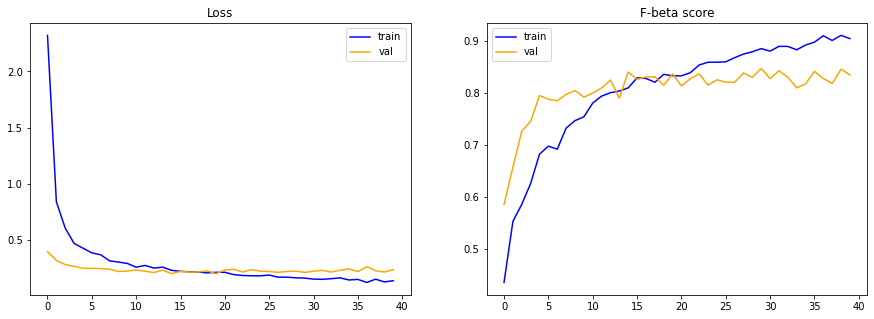

Model F-beta score :  0.8674097657203674


In [35]:
# load VGG16 model
model = vgg16.VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add fully connected part
flatten = Flatten()(model.layers[-1].output)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.3)(fc2)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.4)(fc3)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model5_performance = evaluate_model(history)

# Finalize model 5

In [40]:
# load VGG16 model
model = vgg16.VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add fully connected part
flatten = Flatten()(model.layers[-1].output)
fc1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.3)(fc2)
fc3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.4)(fc3)
fc4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
output = Dense(5, activation='sigmoid')(fc4)

# create model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint('nature_clf.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)

Epoch 1/300
40/40 [==============================] - 7s 153ms/step - loss: 2.3946 - val_loss: 0.4716

Epoch 00001: val_loss improved from inf to 0.47161, saving model to nature_clf.h5
Epoch 2/300
40/40 [==============================] - 6s 144ms/step - loss: 0.8654 - val_loss: 0.3488

Epoch 00002: val_loss improved from 0.47161 to 0.34878, saving model to nature_clf.h5
Epoch 3/300
40/40 [==============================] - 6s 144ms/step - loss: 0.6041 - val_loss: 0.3132

Epoch 00003: val_loss improved from 0.34878 to 0.31315, saving model to nature_clf.h5
Epoch 4/300
40/40 [==============================] - 6s 147ms/step - loss: 0.5291 - val_loss: 0.2856

Epoch 00004: val_loss improved from 0.31315 to 0.28555, saving model to nature_clf.h5
Epoch 5/300
40/40 [==============================] - 6s 147ms/step - loss: 0.4340 - val_loss: 0.2781

Epoch 00005: val_loss improved from 0.28555 to 0.27806, saving model to nature_clf.h5
Epoch 6/300
40/40 [==============================] - 6s 144ms/st

## Save final model to local machine

In [41]:
model = load_model('nature_clf.h5')

In [42]:
# save model
model_json = model.to_json()
with open("nature_clf_model.json", "w") as json_file:
    json_file.write(model_json)
# save weights to HDFS
model.save_weights("nature_clf_weights.h5")

In [45]:
# download model and its weights to local machine
files.download('nature_clf_model.json')
files.download('nature_clf_weights.h5')
files.download('inv_labels_map.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate final model

In [48]:
prep_X_test = vgg16.preprocess_input(X_test)
y_pred = model.predict(prep_X_test)
performance = fbeta(y_test, y_pred).numpy()

print("final model performance (fbeta) : ", performance)

final model performance (fbeta) :  0.8451084


# Make prediction

## Batch prediction for images in folder

In [65]:
# specify folder path
folder_path = '/content/nature_multilabel_image_classification/miml_dataset/images'

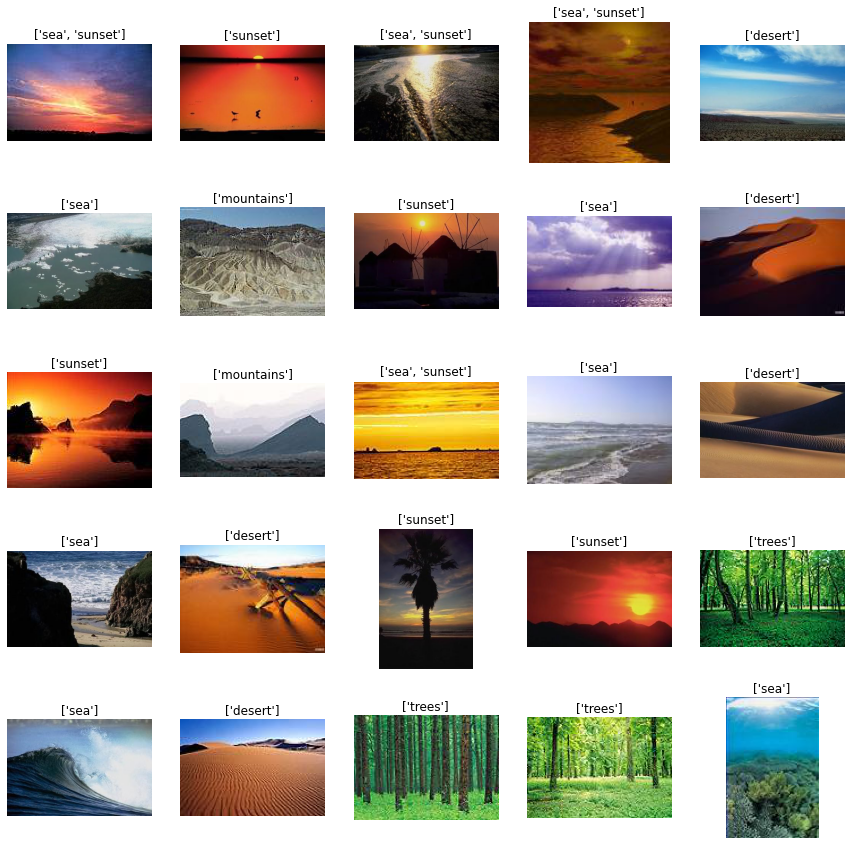

In [74]:
# get list of file name
image_paths = [os.path.join(folder_path, x) for x in os.listdir(folder_path)]

images = []
for path in image_paths :
  img = load_img(path, target_size=(128,128))
  img = img_to_array(img)
  images.append(img)
images = np.array(images)

# preprocess images
images = vgg16.preprocess_input(images)

# make prediction
predictions = model.predict(images)
predictions = np.round(predictions)

# show sample predictions
sample_idx = random.sample(range(len(image_paths)), 25)
plt.figure(figsize=(15,15))
for i, idx in enumerate(sample_idx) :
  plt.subplot(5,5,i+1)
  img = plt.imread(image_paths[idx])
  plt.imshow(img)
  plt.axis('off')
  labels = []
  for j in range(predictions.shape[-1]):
    if predictions[idx][j] == 1 :
      label = inv_labels_map[j]
      labels.append(label)
  plt.title(labels)
plt.show()  

## predict upload image

Saving sea.jpeg to sea (1).jpeg


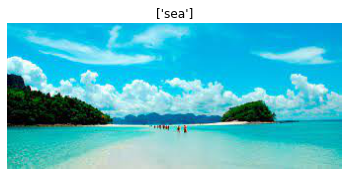

In [77]:
from io import BytesIO
from PIL import Image

uploaded = files.upload()
img_original = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
# resize image
img = img_original.resize((128,128))
# convert to array
img = img_to_array(img)
# expand dimension as a batch
img = np.expand_dims(img, 0)
# preprocess image
img = vgg16.preprocess_input(img)
# make prediction
prediction = np.round(model.predict(img))
# encode prediction
labels = []
for j in range(prediction.shape[-1]):
  if prediction[0][j] == 1 :
    label = inv_labels_map[j]
    labels.append(label)
# show prediction
plt.imshow(img_original)
plt.axis('off')
plt.title(labels)
plt.show()